In [1]:
import os
import sys
import glob
import time
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

%matplotlib inline

In [2]:
from unet import UNet
from fcn import *
from utils import *
from dataset import *

In [3]:
DATA_DIR = 'data/IR-MNIST'
MODEL_PATH = './models/IR-MNIST/'
TRAIN_PATTERN = os.path.join(DATA_DIR, 'Train Samples/*.jpg')
train_paths = glob.glob(TRAIN_PATTERN)

# (112, 112)

## Training

In [4]:
# hyperparams
gamma = 0.4
batch_size = 16
num_epochs = 30
print_intv = 1

In [5]:
g_lr = 2e-4
d_lr = 1e-5

In [6]:
train_dataset = Dataset(train_paths, (112, 112), Image.LANCZOS)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

G = UNet(1, 1).to(device)
D = FCN_112_11(1).to(device)
G_optimizer = optim.Adam(G.parameters(), lr=g_lr)
D_optimizer = optim.Adam(D.parameters(), lr=d_lr)
criterion = nn.BCEWithLogitsLoss()

Epoch 0: 2.2min, D_loss: 1.372146, G_loss: 0.749417


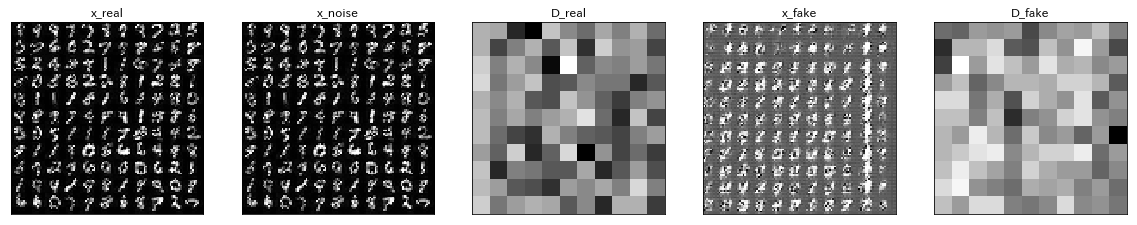

Epoch 1: 2.2min, D_loss: 1.315780, G_loss: 0.717991


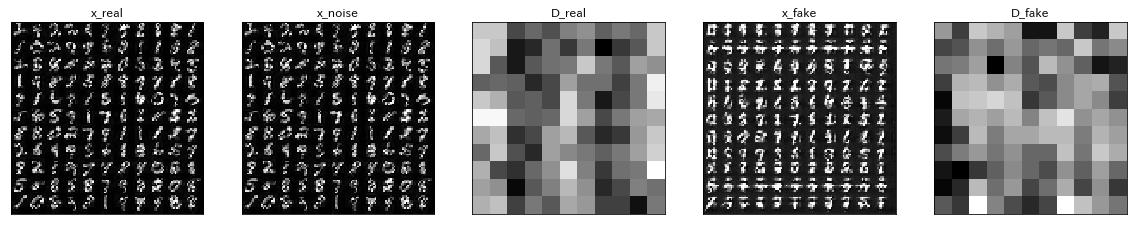

Epoch 2: 2.2min, D_loss: 1.221449, G_loss: 0.805797


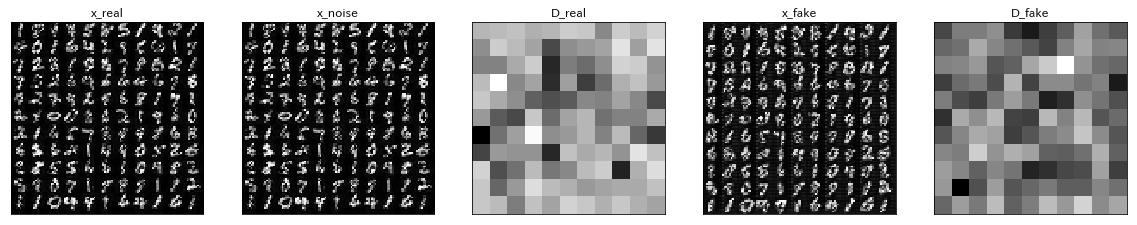

Epoch 3: 2.2min, D_loss: 1.166054, G_loss: 0.843043


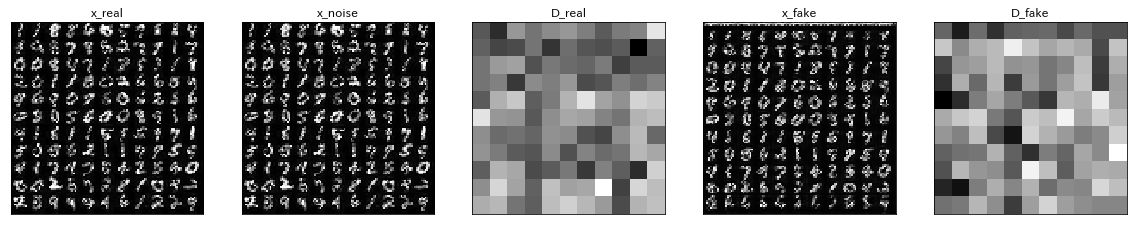

Epoch 4: 2.2min, D_loss: 0.950904, G_loss: 1.029440


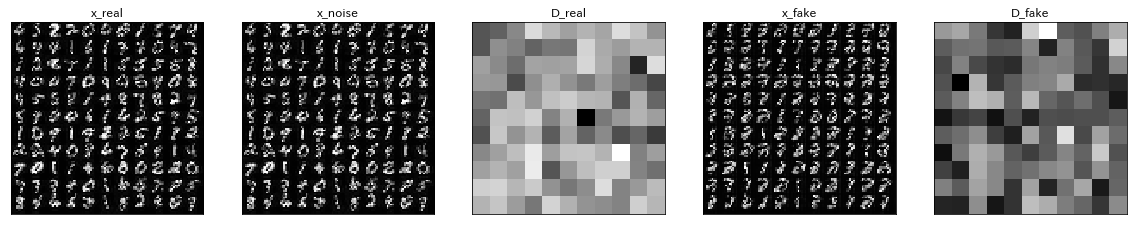

Epoch 5: 2.2min, D_loss: 1.377206, G_loss: 0.704732


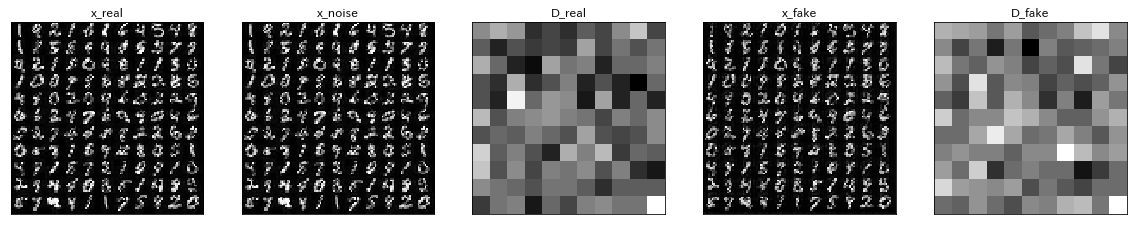

Epoch 6: 2.2min, D_loss: 1.386254, G_loss: 0.700068


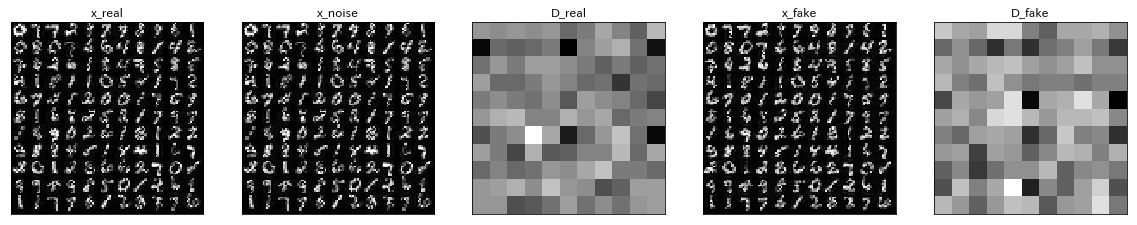

Epoch 7: 2.2min, D_loss: 1.385750, G_loss: 0.696884


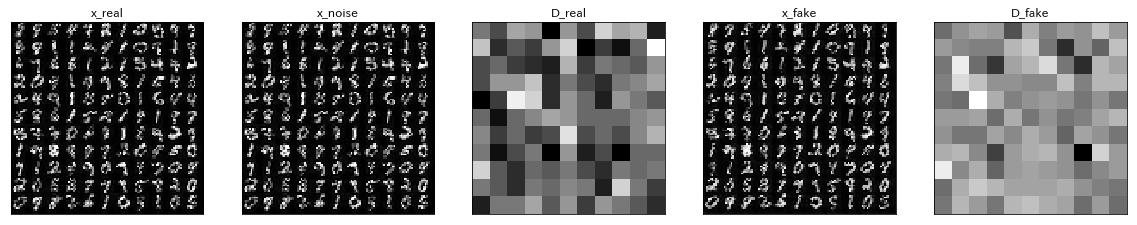

Epoch 8: 2.2min, D_loss: 1.386883, G_loss: 0.694122


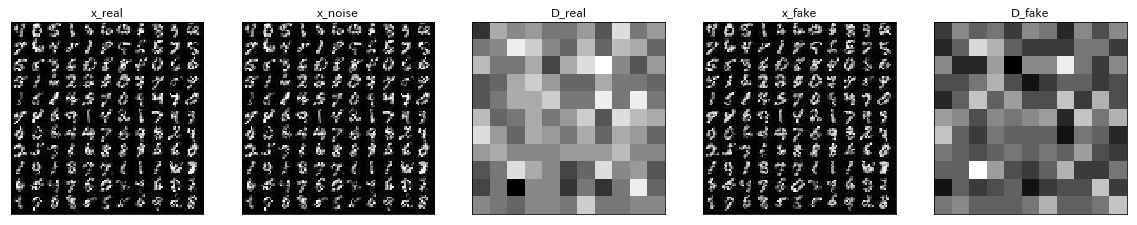

Epoch 9: 2.2min, D_loss: 1.387149, G_loss: 0.692766


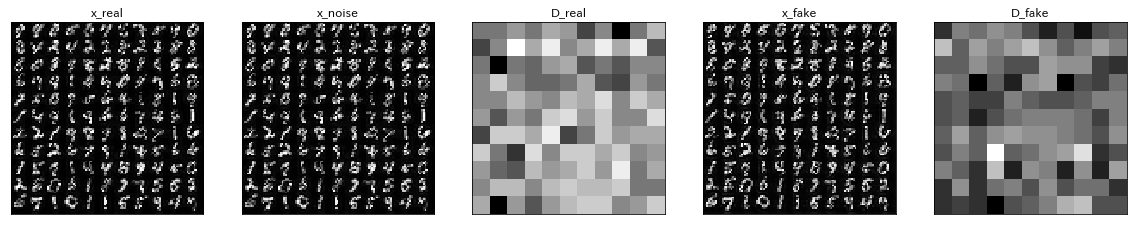

Epoch 10: 2.2min, D_loss: 1.384989, G_loss: 0.695015


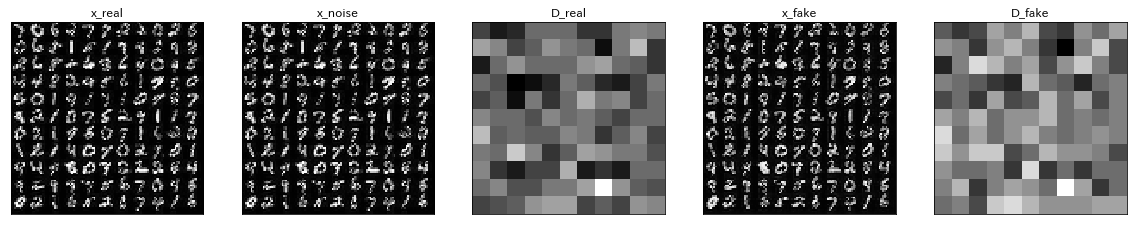

Epoch 11: 2.2min, D_loss: 1.385619, G_loss: 0.691553


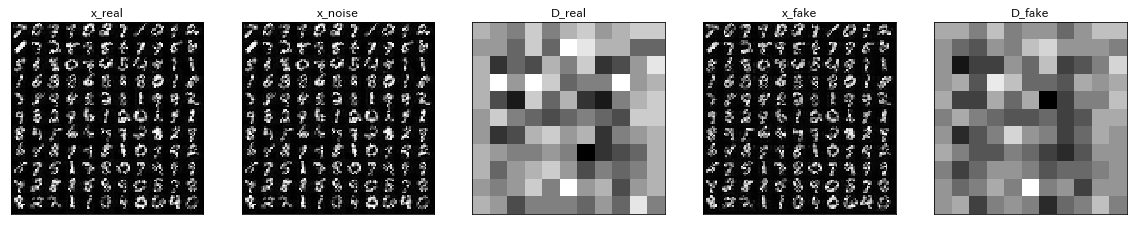

Epoch 12: 2.2min, D_loss: 1.383732, G_loss: 0.692420


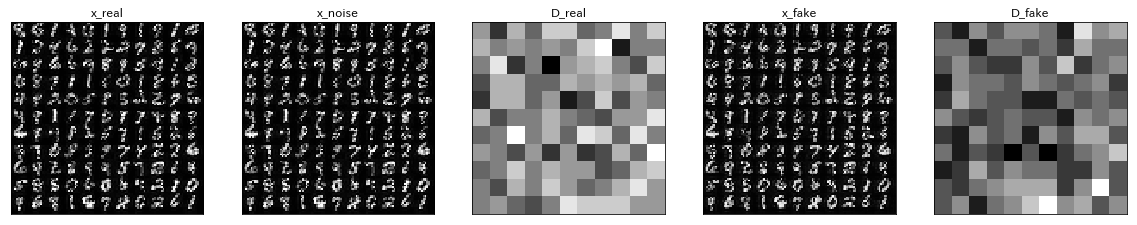

Epoch 13: 2.2min, D_loss: 1.385016, G_loss: 0.695023


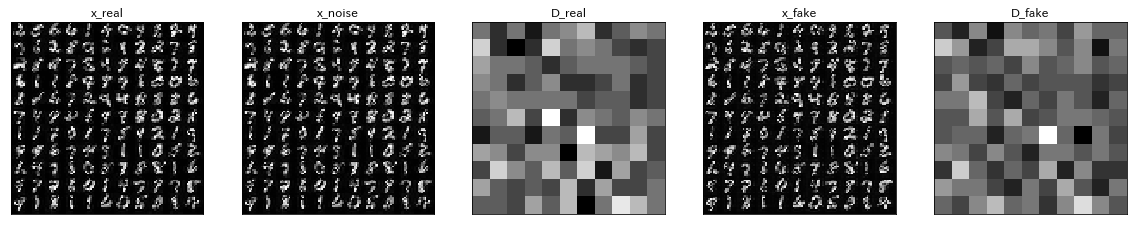

Epoch 14: 2.2min, D_loss: 1.381474, G_loss: 0.692507


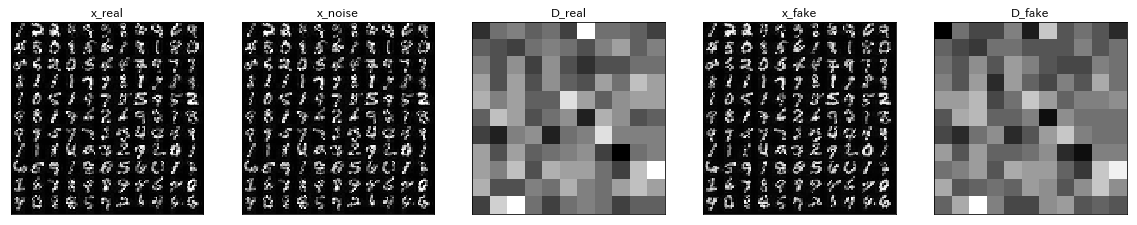

Epoch 15: 2.2min, D_loss: 1.384818, G_loss: 0.696057


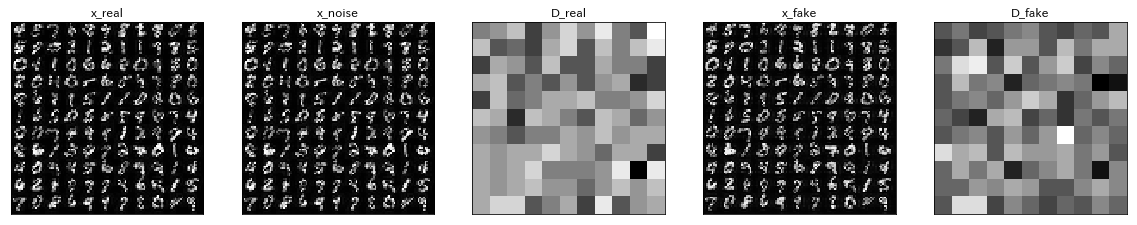

Epoch 16: 2.2min, D_loss: 1.383832, G_loss: 0.694611


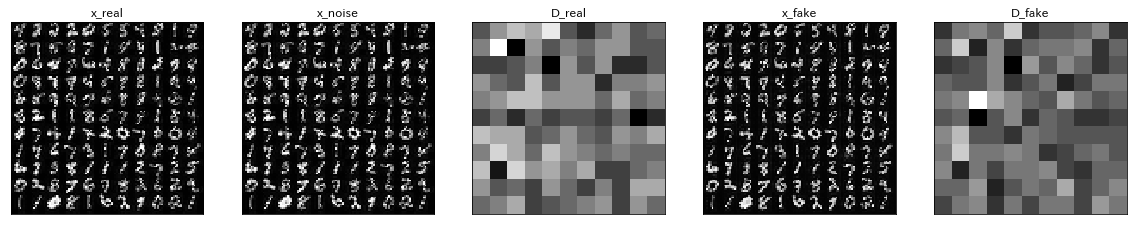

Epoch 17: 2.2min, D_loss: 1.383445, G_loss: 0.695838


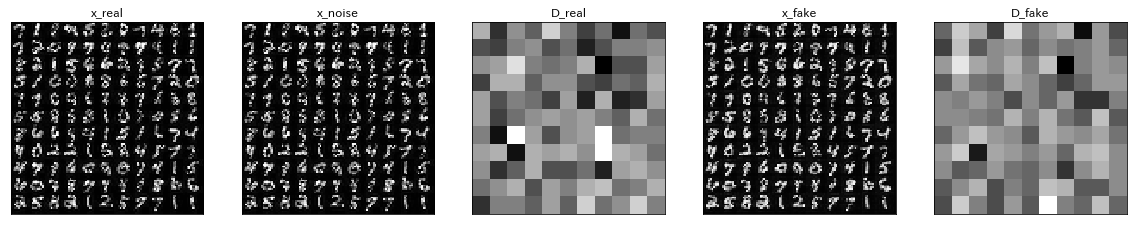

Epoch 18: 2.2min, D_loss: 1.383271, G_loss: 0.693276


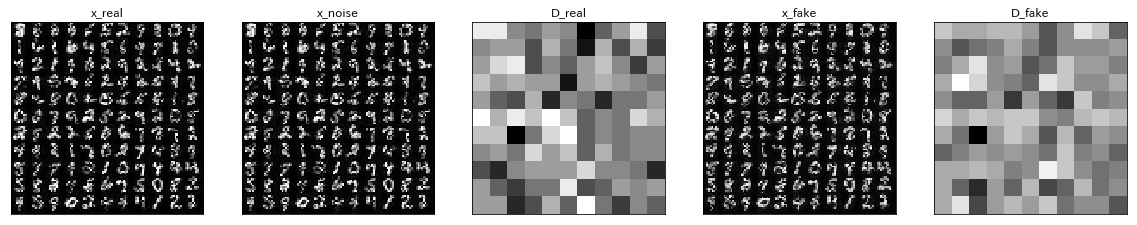

Epoch 19: 2.2min, D_loss: 1.382658, G_loss: 0.696304


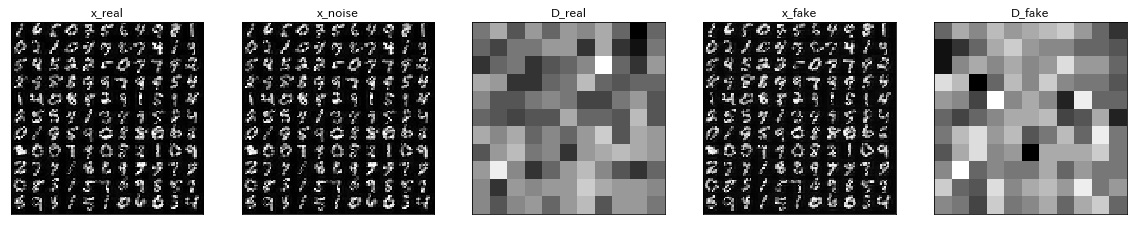

Epoch 20: 2.2min, D_loss: 1.381538, G_loss: 0.693503


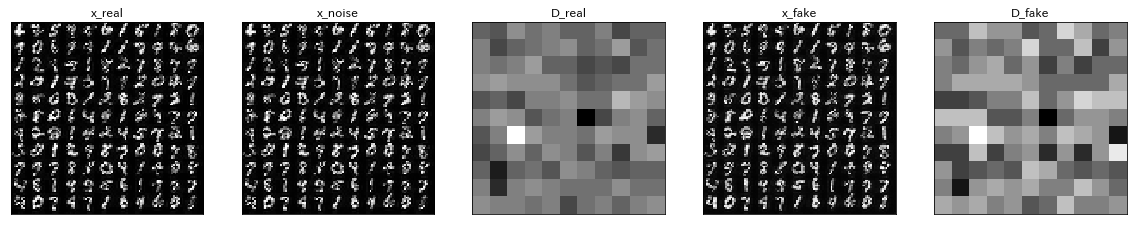

Epoch 21: 2.2min, D_loss: 1.386285, G_loss: 0.690808


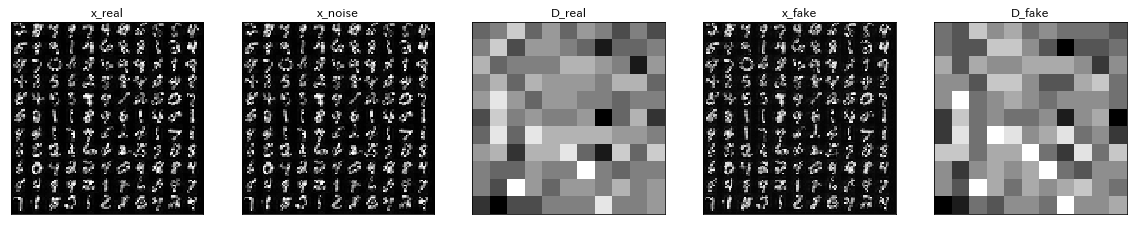

Epoch 22: 2.2min, D_loss: 1.384103, G_loss: 0.691731


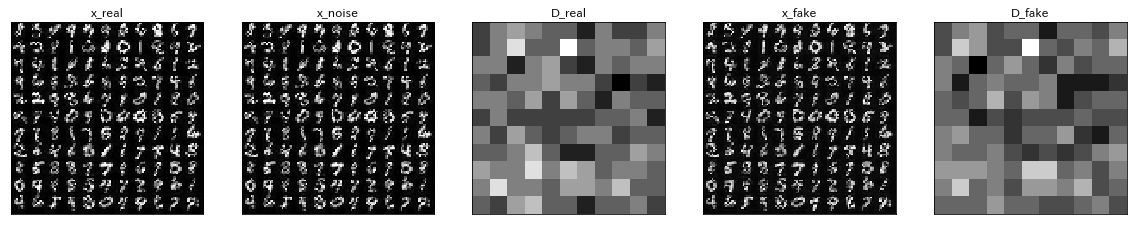

Epoch 23: 2.2min, D_loss: 1.383972, G_loss: 0.689504


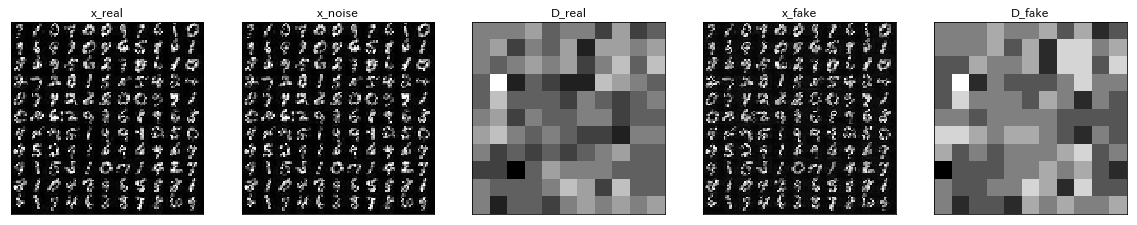

Epoch 24: 2.2min, D_loss: 1.383333, G_loss: 0.692721


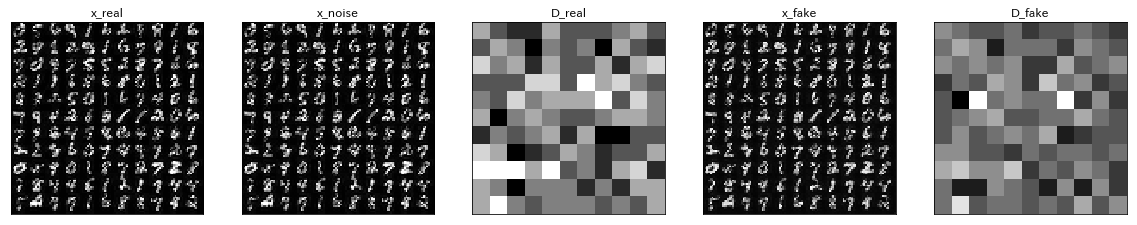

Epoch 25: 2.2min, D_loss: 1.384317, G_loss: 0.691933


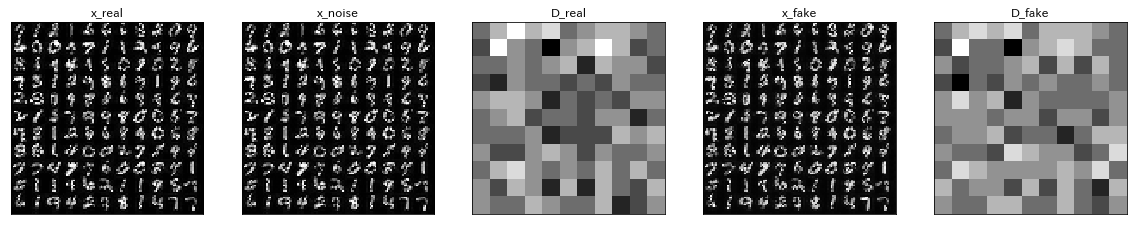

Epoch 26: 2.2min, D_loss: 1.383894, G_loss: 0.692850


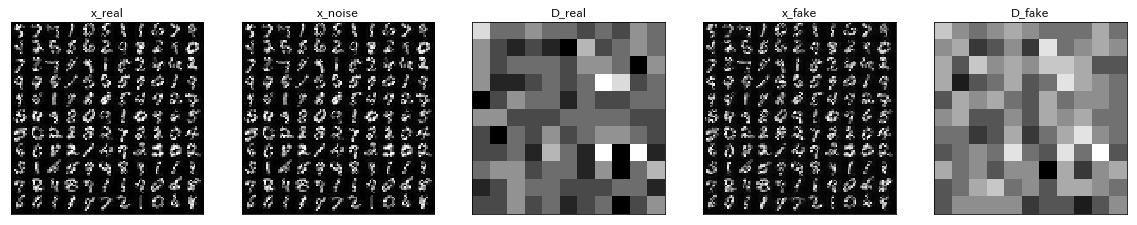

Epoch 27: 2.2min, D_loss: 1.383572, G_loss: 0.690096


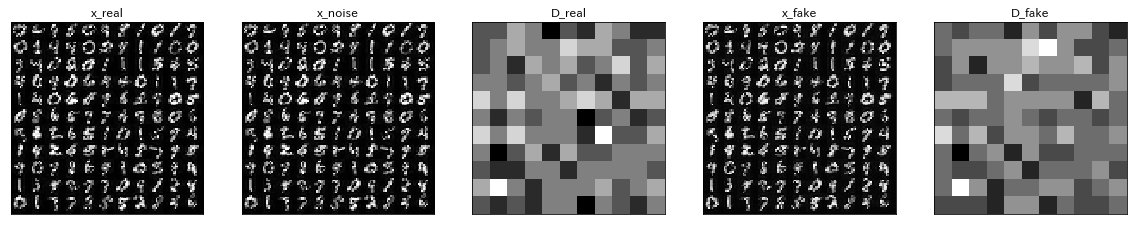

Epoch 28: 2.2min, D_loss: 1.383581, G_loss: 0.691220


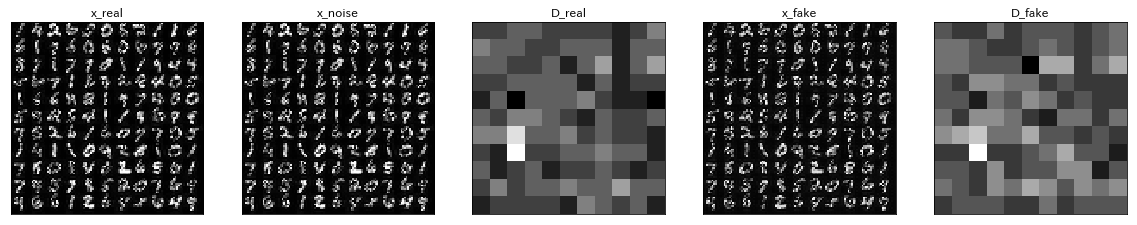

Epoch 29: 2.2min, D_loss: 1.383520, G_loss: 0.691707


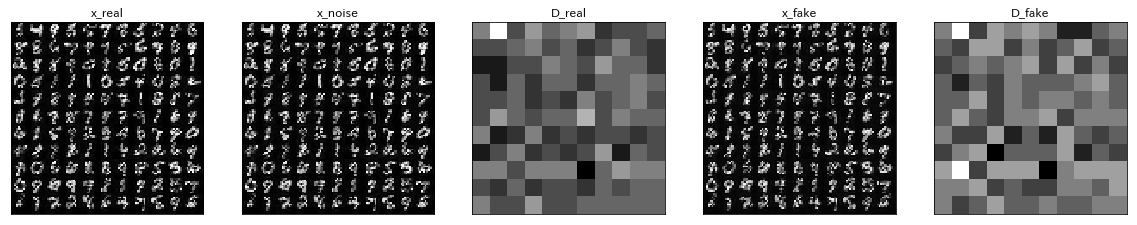

In [8]:
# Training
history = {'D_loss': [], 'G_loss': []}

D.train()
G.train()
D_best_loss = np.inf
G_best_loss = np.inf

for epoch in range(num_epochs):
    D_running_loss = 0
    G_running_loss = 0
    _D_real_loss = 0
    _D_fake_loss = 0
    
    start = time.time()
    for x_real in train_loader:
#         if x_real.size(0) != batch_size:
#             break

        D.zero_grad()
        G.zero_grad()
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()
        
        x_real = x_real.to(device) 

        ### Update Discriminator ###
        # real
        D_real = D(x_real)
        y_real = torch.ones(D_real.size()).to(device)
        y_fake = torch.zeros(D_real.size()).to(device)
        D_real_loss = criterion(D_real, y_real)
        
        # fake
        eta = torch.randn(x_real.size()).to(device)
        x_noise = x_real + gamma * eta / 255
        x_fake = G(x_noise)
        D_fake = D(x_fake.detach())  # detach for computational speed
        D_fake_loss = criterion(D_fake, y_fake)
        
        # update params
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()
        # for debug
        _D_real_loss += D_real_loss.item()
        _D_fake_loss += D_fake_loss.item()
        
        ### Update Generator ###
        eta = torch.randn(x_real.size()).to(device)
        x_noise = x_real + gamma * eta / 255
        x_fake = G(x_noise)
        D_fake = D(x_fake)
        
        # update params
        G_loss = criterion(D_fake, y_real)
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
    
        imgs = {
            'x_real': x_real,
            'x_noise': x_noise,
            'D_real': torch.sigmoid(D_real),
            'x_fake': x_fake,
            'D_fake': torch.sigmoid(D_fake),
        }
        
    elapsed_time = (time.time() - start) / 60
    
    D_running_loss /= len(train_loader)
    G_running_loss /= len(train_loader)
    history['D_loss'].append(D_running_loss)
    history['G_loss'].append(G_running_loss)
    
    torch.save(D.state_dict(), MODEL_PATH+'D_{:03d}.pth'.format(epoch))
    torch.save(G.state_dict(), MODEL_PATH+'G_{:03d}.pth'.format(epoch))
    
    if D_running_loss < D_best_loss:
        D_best_loss = D_running_loss
        torch.save(D.state_dict(), MODEL_PATH+'D.pth'.format(epoch))
    if G_running_loss < G_best_loss:
        G_best_loss = G_running_loss
        torch.save(G.state_dict(), MODEL_PATH+'G.pth')
    
    print('Epoch {}: {:.1f}min, D_loss: {:.6f}, G_loss: {:.6f}'.format(epoch, elapsed_time, D_running_loss, G_running_loss))
    
    if epoch % print_intv == 0:
        idxs = np.random.randint(0, batch_size, [1])
        show_imgs(imgs, idxs)

In [11]:
x_real = imgs['x_real']

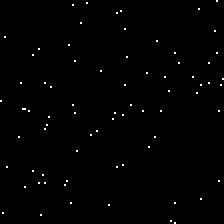

In [12]:
diff = x_real - x_noise
convert_tensor_to_PIL(diff[0]).resize([224,224])

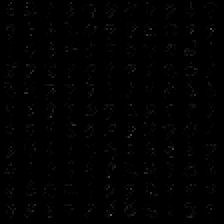

In [13]:
diff = torch.pow(x_real-x_fake, 2)
convert_tensor_to_PIL(diff[0]).resize([224,224])

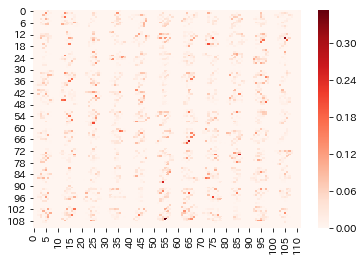

In [14]:
diff = torch.pow(x_real-x_fake, 2)
sns.heatmap(diff.data.cpu().numpy()[0,0], cmap='Reds')

## 推論

In [15]:
TEST_PATTERN = os.path.join(DATA_DIR, 'Test Samples/*.jpg')
test_paths = glob.glob(TEST_PATTERN)
test_dataset = Dataset(test_paths, (112, 112))
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False)

In [16]:
for x_path, x_real in zip(test_paths, test_loader):
    break

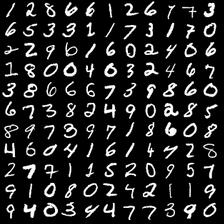

In [17]:
Image.open(x_path)

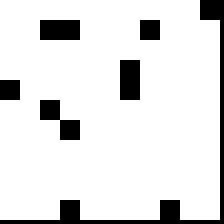

In [18]:
file = x_path.split('/')[-1]
gt = os.path.join(DATA_DIR, 'GT/gt_' + file)
Image.open(gt)

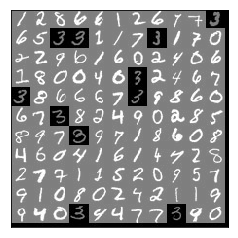

In [19]:
x_img = Image.open(x_path)
gt_img = Image.open(gt)
plt.imshow(x_img)
plt.imshow(gt_img, alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.show()

In [20]:
x_real = x_real.to(device)

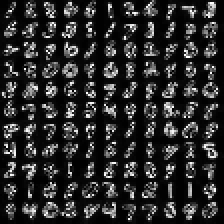

In [28]:
transforms.ToPILImage()(x_real[0].cpu()).resize((224,224))

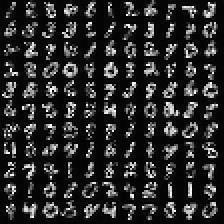

In [21]:
x_fake = G(x_real)
transforms.ToPILImage()(x_fake[0].cpu()).resize((224,224))

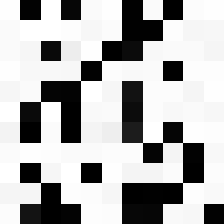

In [22]:
D_real = D(x_real)
transforms.ToPILImage()(D_real[0].cpu()).resize((224,224))

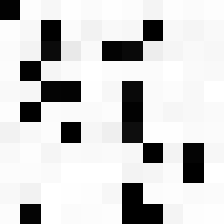

In [23]:
D_fake = D(x_fake)
transforms.ToPILImage()(D_fake[0].cpu()).resize((224,224))

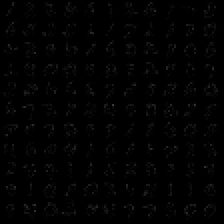

In [24]:
diff = torch.pow(x_real-x_fake, 2)
convert_tensor_to_PIL(diff[0]).resize([224,224])

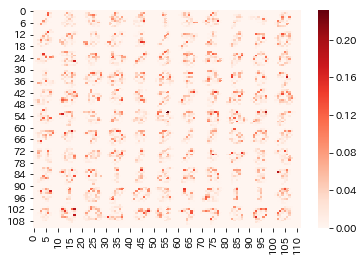

In [25]:
diff = torch.pow(x_real-x_fake, 2)
sns.heatmap(diff.data.cpu().numpy()[0,0], cmap='Reds')

# (224, 224)

## Training

In [4]:
# hyperparams
gamma = 0.4
batch_size = 16
num_epochs = 30
print_intv = 1

In [5]:
g_lr = 2e-4
d_lr = 1e-5

In [32]:
train_dataset = Dataset(train_paths)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

G = UNet(1, 1).to(device)
D = FCN_224_11(1).to(device)
G_optimizer = optim.Adam(G.parameters(), lr=g_lr)
D_optimizer = optim.Adam(D.parameters(), lr=d_lr)
criterion = nn.BCEWithLogitsLoss()

Epoch 0: 5.7min, D_loss: 1.389765, G_loss: 0.676015


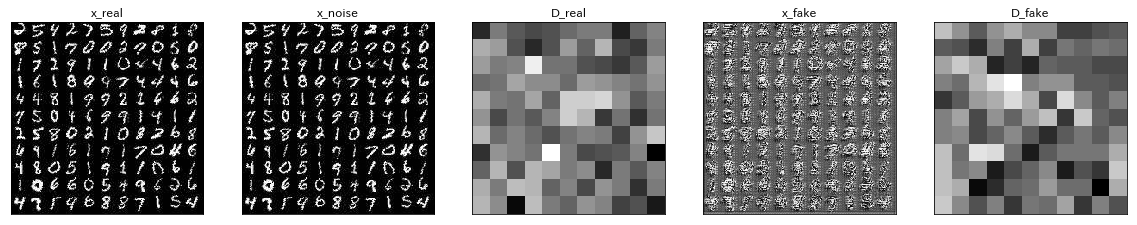

Epoch 1: 5.7min, D_loss: 1.386535, G_loss: 0.694966


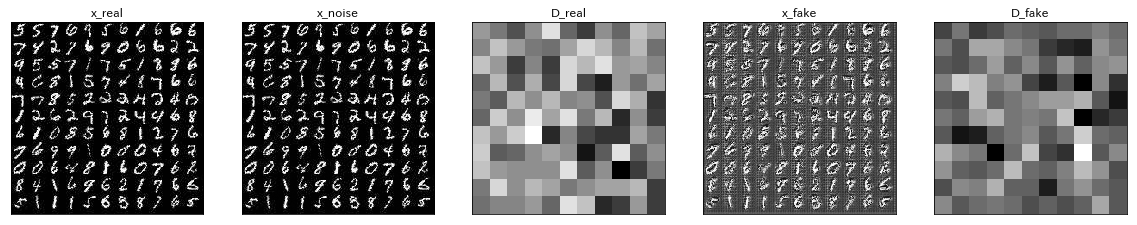

Epoch 2: 5.7min, D_loss: 1.385512, G_loss: 0.695164


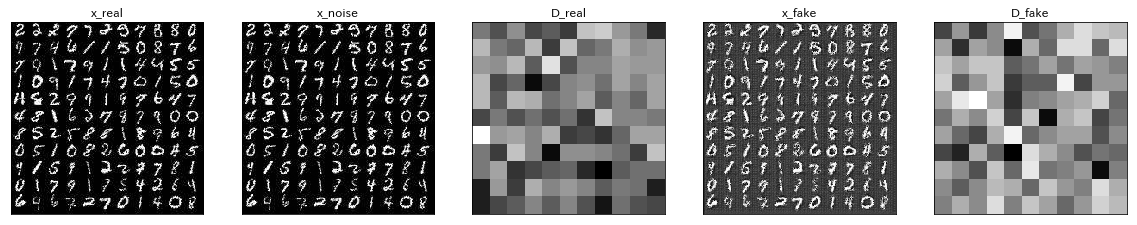

Epoch 3: 5.7min, D_loss: 1.384058, G_loss: 0.695924


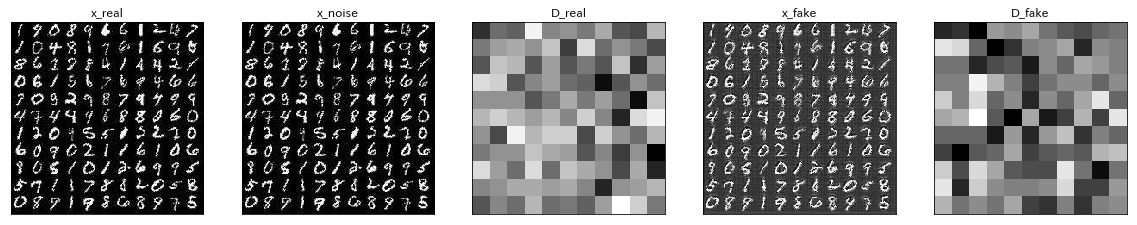

Epoch 4: 5.7min, D_loss: 1.382695, G_loss: 0.696654


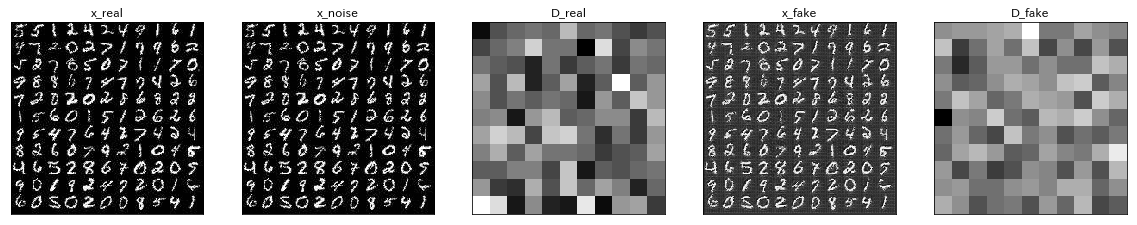

Epoch 5: 5.7min, D_loss: 1.382603, G_loss: 0.696607


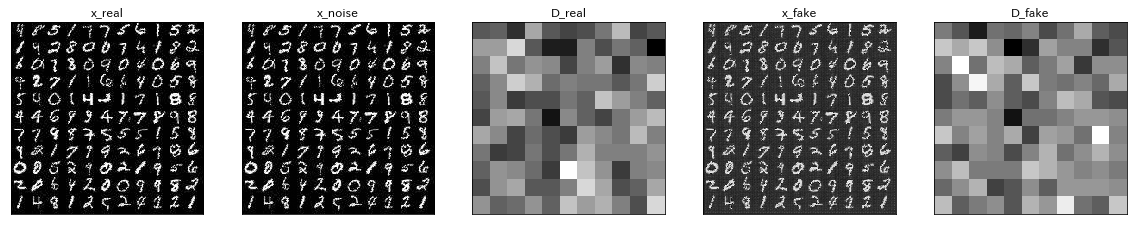

KeyboardInterrupt: 

In [33]:
# Training
history = {'D_loss': [], 'G_loss': []}

D.train()
G.train()
D_best_loss = np.inf
G_best_loss = np.inf

for epoch in range(num_epochs):
    D_running_loss = 0
    G_running_loss = 0
    _D_real_loss = 0
    _D_fake_loss = 0
    
    start = time.time()
    for x_real in train_loader:

        D.zero_grad()
        G.zero_grad()
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()
        
        x_real = x_real.to(device) 

        ### Update Discriminator ###
        # real
        D_real = D(x_real)
        y_real = torch.ones(D_real.size()).to(device)
        y_fake = torch.zeros(D_real.size()).to(device)
        D_real_loss = criterion(D_real, y_real)
        
        # fake
        eta = torch.randn(x_real.size()).to(device)
        x_noise = x_real + gamma * eta / 255
        x_fake = G(x_noise)
        D_fake = D(x_fake.detach())  # detach for computational speed
        D_fake_loss = criterion(D_fake, y_fake)
        
        # update params
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()
        # for debug
        _D_real_loss += D_real_loss.item()
        _D_fake_loss += D_fake_loss.item()
        
        ### Update Generator ###
        eta = torch.randn(x_real.size()).to(device)
        x_noise = x_real + gamma * eta / 255
        x_fake = G(x_noise)
        D_fake = D(x_fake)
        
        # update params
        G_loss = criterion(D_fake, y_real)
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
    
        imgs = {
            'x_real': x_real,
            'x_noise': x_noise,
            'D_real': torch.sigmoid(D_real),
            'x_fake': x_fake,
            'D_fake': torch.sigmoid(D_fake),
        }
        
    elapsed_time = (time.time() - start) / 60
    
    D_running_loss /= len(train_loader)
    G_running_loss /= len(train_loader)
    history['D_loss'].append(D_running_loss)
    history['G_loss'].append(G_running_loss)
    
    torch.save(D.state_dict(), MODEL_PATH+'D_{:03d}.pth'.format(epoch))
    torch.save(G.state_dict(), MODEL_PATH+'G_{:03d}.pth'.format(epoch))
    
    if D_running_loss < D_best_loss:
        D_best_loss = D_running_loss
        torch.save(D.state_dict(), MODEL_PATH+'D.pth'.format(epoch))
    if G_running_loss < G_best_loss:
        G_best_loss = G_running_loss
        torch.save(G.state_dict(), MODEL_PATH+'G.pth')
    
    print('Epoch {}: {:.1f}min, D_loss: {:.6f}, G_loss: {:.6f}'.format(epoch, elapsed_time, D_running_loss, G_running_loss))
    
    if epoch % print_intv == 0:
        idxs = np.random.randint(0, x_real.size(0), [1])
        show_imgs(imgs, idxs)

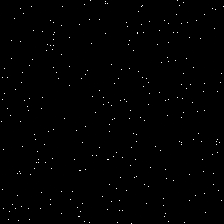

In [34]:
diff = x_real - x_noise
convert_tensor_to_PIL(diff[0]).resize([224,224])

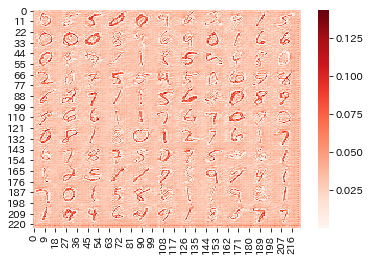

In [36]:
diff = torch.pow(x_real-x_fake, 2)
sns.heatmap(diff.data.cpu().numpy()[0,0], cmap='Reds')

## 推論

In [42]:
TEST_PATTERN = os.path.join(DATA_DIR, 'Test Samples/*.jpg')
test_paths = glob.glob(TEST_PATTERN)
test_dataset = Dataset(test_paths)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False)

In [43]:
for x_path, x_real in zip(test_paths, test_loader):
    break

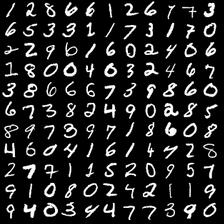

In [44]:
Image.open(x_path)

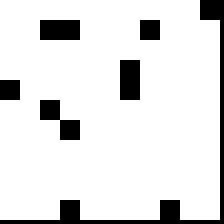

In [45]:
file = x_path.split('/')[-1]
gt = os.path.join(DATA_DIR, 'GT/gt_' + file)
Image.open(gt)

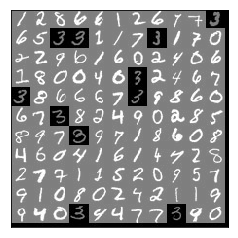

In [46]:
x_img = Image.open(x_path)
gt_img = Image.open(gt)
plt.imshow(x_img)
plt.imshow(gt_img, alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.show()

In [47]:
x_real = x_real.to(device)

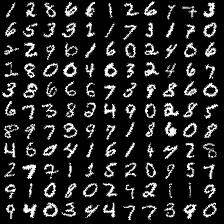

In [50]:
transforms.ToPILImage()(x_real[0].cpu())

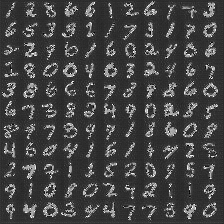

In [51]:
x_fake = G(x_real)
transforms.ToPILImage()(x_fake[0].cpu())

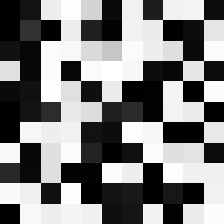

In [52]:
D_real = D(x_real)
transforms.ToPILImage()(D_real[0].cpu()).resize((224,224))

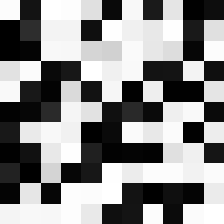

In [53]:
D_fake = D(x_fake)
transforms.ToPILImage()(D_fake[0].cpu()).resize((224,224))

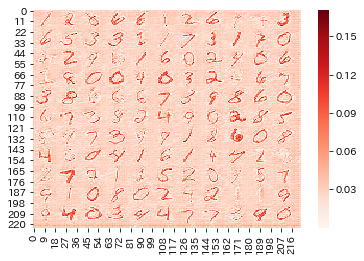

In [55]:
diff = torch.pow(x_real-x_fake, 2)
sns.heatmap(diff.data.cpu().numpy()[0,0], cmap='Reds')